In [1]:
import gym
import random
import numpy as np
import tflearn
import matplotlib.pyplot as plt
%matplotlib inline

curses is not supported on this machine (please install/reinstall curses for an optimal experience)


In [2]:
from tflearn.layers.core import input_data, dropout, fully_connected

In [3]:
from tflearn.layers.estimator import regression
from statistics import mean, median
from collections import Counter

In [4]:
LR = 1e-3
env = gym.make('CartPole-v0')

In [5]:
env.reset()

array([-0.00744777,  0.02525137, -0.03276514,  0.01921652])

In [6]:
goal_steps = 500

In [7]:
score_requiremnts = 50
initial_games = 10000

In [8]:
def some_randdom_games_first():
    for episode in range(5):
        env.reset()
        for t in range(goal_steps):
#             env.render()
            action = env.action_space.sample()
            observation, reward, done, info = env.step(action)
#             print(observation, reward, done, info)
            if done:
                break

In [9]:
some_randdom_games_first()

In [10]:
def initial_population():
    training_data = []
    scores = []
    accepted_scores = []
    
    for _ in range(initial_games):
        score = 0
        game_memory = []
        prev_observation = []
        for _ in range(goal_steps):
            action = random.randrange(0,2)
            observation, reward, done, info = env.step(action)
            
            if len(prev_observation) > 0:
                game_memory.append([prev_observation, action])
            
            prev_observation = observation
            
            score += reward
            if done:
                break
                
        if score >= score_requiremnts:
            accepted_scores.append(score)
            for data in game_memory:
                if data[1] == 1:
                    output = [0,1]
                elif data[1] == 0:
                    output = [1,0]
                training_data.append([data[0], output])
        
        env.reset()
        scores.append(score)
        
    training_data_save = np.array(training_data)
    np.save('saved.npy', training_data_save)
    
    print('Average accepted score: ', mean(accepted_scores))
    print('Median accepted score: ', median(accepted_scores))
    print(Counter(accepted_scores))
    
    return training_data

                    

In [18]:
training_data = initial_population()

You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


Average accepted score:  60.39588688946015
Median accepted score:  56.0
Counter({50.0: 37, 51.0: 35, 52.0: 33, 55.0: 25, 53.0: 23, 54.0: 22, 56.0: 21, 60.0: 20, 58.0: 19, 57.0: 13, 61.0: 11, 65.0: 11, 59.0: 10, 68.0: 9, 64.0: 8, 69.0: 8, 70.0: 7, 67.0: 6, 63.0: 6, 62.0: 6, 73.0: 5, 71.0: 5, 83.0: 4, 76.0: 4, 77.0: 4, 80.0: 4, 66.0: 4, 92.0: 4, 90.0: 3, 74.0: 3, 75.0: 2, 97.0: 2, 96.0: 2, 86.0: 2, 103.0: 1, 93.0: 1, 88.0: 1, 104.0: 1, 72.0: 1, 106.0: 1, 82.0: 1, 119.0: 1, 87.0: 1, 79.0: 1, 99.0: 1})


In [12]:
def neural_network_model(input_size):

    network = input_data(shape=[None, input_size, 1], name='input')

    network = fully_connected(network, 128, activation='relu')
    network = dropout(network, 0.8)

    network = fully_connected(network, 256, activation='relu')
    network = dropout(network, 0.8)

    network = fully_connected(network, 512, activation='relu')
    network = dropout(network, 0.8)

    network = fully_connected(network, 256, activation='relu')
    network = dropout(network, 0.8)

    network = fully_connected(network, 128, activation='relu')
    network = dropout(network, 0.8)

    network = fully_connected(network, 2, activation='softmax')
    network = regression(network, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')
    model = tflearn.DNN(network, tensorboard_dir='log')

    return model

In [13]:
def train_model(training_data, model=False):

    X = np.array([i[0] for i in training_data]).reshape(-1,len(training_data[0][0]),1)
    y = [i[1] for i in training_data]

    if not model:
        model = neural_network_model(input_size = len(X[0]))
    
    model.fit({'input': X}, {'targets': y}, n_epoch=3, snapshot_step=500, show_metric=True, run_id='openai_learning')
    return model

In [19]:
model = train_model(training_data)

---------------------------------
Run id: openai_learning
Log directory: log/
INFO:tensorflow:Summary name Accuracy/Adam_0 (raw) is illegal; using Accuracy/Adam_0__raw_ instead.
INFO:tensorflow:Summary name Accuracy_1/Adam_1 (raw) is illegal; using Accuracy_1/Adam_1__raw_ instead.
---------------------------------
Training samples: 46210
Validation samples: 0
--


InvalidArgumentError: You must feed a value for placeholder tensor 'input_1/X' with dtype float
	 [[Node: input_1/X = Placeholder[dtype=DT_FLOAT, shape=[], _device="/job:localhost/replica:0/task:0/gpu:0"]()]]
	 [[Node: Crossentropy_1/Mean/moving_avg/read/_45 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_51_Crossentropy_1/Mean/moving_avg/read", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op 'input_1/X', defined at:
  File "C:\ProgramData\Anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\ProgramData\Anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\ProgramData\Anaconda3\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "C:\ProgramData\Anaconda3\lib\site-packages\zmq\eventloop\ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "C:\ProgramData\Anaconda3\lib\site-packages\tornado\ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "C:\ProgramData\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\ProgramData\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2698, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2802, in run_ast_nodes
    if self.run_code(code, result):
  File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-19-66fbf623f7ca>", line 1, in <module>
    model = train_model(training_data)
  File "<ipython-input-13-9d60376f2d56>", line 7, in train_model
    model = neural_network_model(input_size = len(X[0]))
  File "<ipython-input-12-bb67ab936e60>", line 3, in neural_network_model
    network = input_data(shape=[None, input_size, 1], name='input')
  File "C:\ProgramData\Anaconda3\lib\site-packages\tflearn\layers\core.py", line 81, in input_data
    placeholder = tf.placeholder(shape=shape, dtype=dtype, name="X")
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\array_ops.py", line 1507, in placeholder
    name=name)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\gen_array_ops.py", line 1997, in _placeholder
    name=name)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 768, in apply_op
    op_def=op_def)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 2336, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 1228, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): You must feed a value for placeholder tensor 'input_1/X' with dtype float
	 [[Node: input_1/X = Placeholder[dtype=DT_FLOAT, shape=[], _device="/job:localhost/replica:0/task:0/gpu:0"]()]]
	 [[Node: Crossentropy_1/Mean/moving_avg/read/_45 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_51_Crossentropy_1/Mean/moving_avg/read", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]


Average Score: 198.9
choice 1:0.49824032176973354  choice 0:0.5017596782302665
50


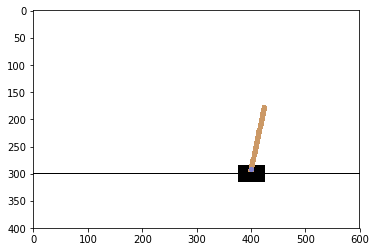

In [17]:
scores = []
choices = []
for each_game in range(10):
    score = 0
    game_memory = []
    prev_obs = []
    env.reset()
    for _ in range(goal_steps):
        plt.imshow(env.render(mode='rgb_array'))

        if len(prev_obs) == 0:
            action = random.randrange(0, 2)
        else:
            action = np.argmax(model.predict(prev_obs.reshape(-1, len(prev_obs), 1))[0])

        choices.append(action)

        new_observation, reward, done, info = env.step(action)
        prev_obs = new_observation
        game_memory.append([new_observation, action])
        score += reward
        if done: break

    scores.append(score)
print('Average Score:', sum(scores) / len(scores))
print('choice 1:{}  choice 0:{}'.format(choices.count(1) / len(choices), choices.count(0) / len(choices)))
print(score_requiremnts)


In [ ]:
model.save('stick_{}.model'.format(str(sum(scores) / len(scores))))